In [1]:
import sys
import os

# Get the root directory
root_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))

# Add the root directory to the Python path
sys.path.append(root_dir)

In [2]:
import torch
from kan import *
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler, LabelEncoder
import pandas as pd

if torch.cuda.is_available():
  device = torch.device("cuda")
else:
  device = torch.device("cpu")

print(device)

cuda


In [3]:
def load_transaction_dataset(csv_path):
    # Load dataset from CSV
    df = pd.read_csv(csv_path)

    # Encode categorical columns
    categorical_columns = ['Gender', 'Product_Category']
    encoders = {col: LabelEncoder() for col in categorical_columns}
    for col in categorical_columns:
        df[col] = encoders[col].fit_transform(df[col])

    # Drop irrelevant columns for machine learning
    features_to_drop = ['Transaction_ID', 'Date', 'Customer_ID']  # Not relevant for ML models
    df = df.drop(columns=features_to_drop)

    # Separate features and target (optional, depending on task)
    # Assuming 'Total_Amount' as the target for regression analysis
    target_column = 'Total_Amount'
    features = df.drop(columns=[target_column])
    target = df[target_column]

    # Standardize numerical features
    scaler = StandardScaler()
    features = scaler.fit_transform(features)

    # Convert to PyTorch tensors
    features_tensor = torch.tensor(features, dtype=torch.float32)
    target_tensor = torch.tensor(target.values, dtype=torch.float32)

    # Split into train and test sets
    train_data, test_data, train_target, test_target = train_test_split(
        features_tensor, target_tensor, test_size=0.1, random_state=42
    )

    # Create data loaders (optional, for batching and shuffling)
    train_loader = torch.utils.data.DataLoader(
        torch.utils.data.TensorDataset(train_data, train_target), batch_size=1, shuffle=True
    )
    test_loader = torch.utils.data.DataLoader(
        torch.utils.data.TensorDataset(test_data, test_target), batch_size=1, shuffle=False
    )

    train_inputs = torch.empty(0, features.shape[1], device=device)
    train_labels = torch.empty(0, dtype=torch.float32, device=device)
    test_inputs = torch.empty(0, features.shape[1], device=device)
    test_labels = torch.empty(0, dtype=torch.float32, device=device)

    # Concatenate all data into single tensors on the specified device
    for data, labels in tqdm(train_loader):
        train_inputs = torch.cat((train_inputs, data.to(device)), dim=0)
        train_labels = torch.cat((train_labels, labels.to(device)), dim=0)

    for data, labels in tqdm(test_loader):
        test_inputs = torch.cat((test_inputs, data.to(device)), dim=0)
        test_labels = torch.cat((test_labels, labels.to(device)), dim=0)

    # Create and return the dataset dictionary
    dataset = {
        'train_input': train_inputs,
        'test_input': test_inputs,
        'train_label': train_labels.reshape(-1, 1),
        'test_label': test_labels.reshape(-1, 1)
    }

    return dataset

# Example usage:
csv_path = "data/retail_sales_dataset.csv"
dataset = load_transaction_dataset(csv_path)


100%|██████████| 100/100 [00:00<00:00, 8690.16it/s]


In [4]:
print("Train data shape: {}".format(dataset['train_input'].shape))
print("Train target shape: {}".format(dataset['train_label'].shape))
print("Test data shape: {}".format(dataset['test_input'].shape))
print("Test target shape: {}".format(dataset['test_label'].shape))
print("====================================")

Train data shape: torch.Size([900, 5])
Train target shape: torch.Size([900, 1])
Test data shape: torch.Size([100, 5])
Test target shape: torch.Size([100, 1])


checkpoint directory created: ./model
saving model version 0.0


| train_loss: 3.02e+00 | test_loss: 2.96e+00 | reg: 1.22e+02 | : 100%|█| 80/80 [00:20<00:00,  3.95it


saving model version 0.1


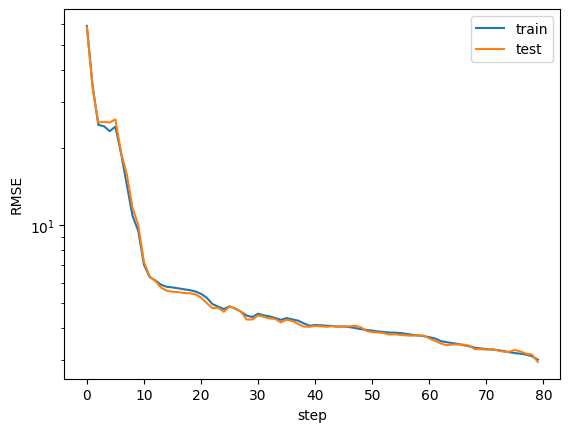

In [5]:
model = KAN(width=[5, 3, 1], grid=3, k=3, seed=381, device=device)
results = model.fit(dataset, opt="LBFGS", steps=80, lamb=0.01, lamb_entropy=0.1, reg_metric='edge_forward_spline_u')
plt.plot(results['train_loss'])
plt.plot(results['test_loss'])
plt.legend(['train', 'test'])
plt.ylabel('RMSE')
plt.xlabel('step')
plt.yscale('log')

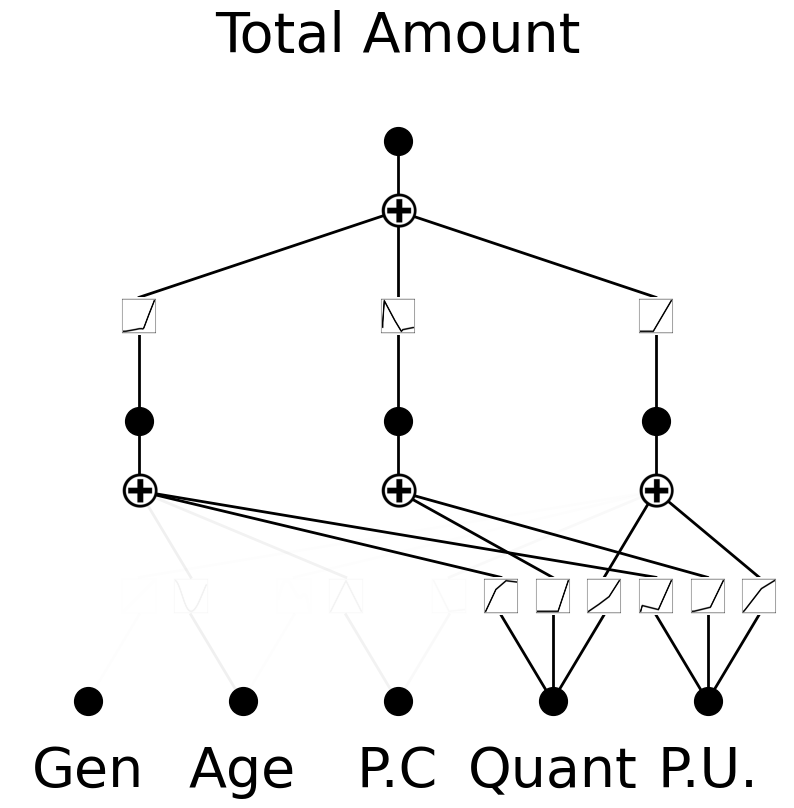

In [6]:
model.plot(beta=50, scale=1, in_vars=['Gen','Age','P.C','Quant','P.U.'], out_vars=['Total Amount'])

# Show Feature Importance

In [7]:
model.feature_score

tensor([9.4496e-04, 2.6143e-03, 1.9834e-03, 9.1108e-01, 1.0348e+00],
       device='cuda:0', grad_fn=<MeanBackward1>)

In [8]:
lib = ['x','x^2','x^3','x^4','exp','log','sqrt','tanh','sin','tan','abs']
model.auto_symbolic(lib=lib)

fixing (0,0,0) with x, r2=1.0000004768371582, c=1
fixing (0,0,1) with exp, r2=1.0000004768371582, c=2
fixing (0,0,2) with x, r2=1.0000007152557373, c=1
fixing (0,1,0) with x, r2=0.22992080450057983, c=1
fixing (0,1,1) with x^2, r2=0.9870216250419617, c=2
fixing (0,1,2) with x, r2=0.1447891741991043, c=1
fixing (0,2,0) with x^2, r2=1.0000008344650269, c=2
fixing (0,2,1) with exp, r2=1.0000004768371582, c=2
fixing (0,2,2) with x^2, r2=1.0000008344650269, c=2
fixing (0,3,0) with sin, r2=1.0000004768371582, c=2
fixing (0,3,1) with exp, r2=0.9999838471412659, c=2
fixing (0,3,2) with tan, r2=1.0000003576278687, c=3
fixing (0,4,0) with sin, r2=0.9999300241470337, c=2
fixing (0,4,1) with x^2, r2=0.9999843835830688, c=2
fixing (0,4,2) with sin, r2=1.0000007152557373, c=2
fixing (1,0,0) with exp, r2=0.9749199151992798, c=2
fixing (1,1,0) with x, r2=0.2245001345872879, c=1
fixing (1,2,0) with x, r2=0.7796705961227417, c=1
saving model version 0.2


In [9]:
formula = model.symbolic_formula()[0][0]

In [10]:
ex_round(formula, 4)

-0.2992*x_1 + 0.3695*x_2 + 0.0135*(0.2007 - x_2)**2 - 0.9709*(-0.2802*x_3 - 1)**2 - 24.3115*(-x_5 - 0.7259)**2 - 0.0002*exp(9.9247*x_4) + 63.3889*exp(0.0014*x_1 - 0.0017*x_2 - 0.0104*(1 - 0.1466*x_3)**2 - 1.7507*sin(8.223*x_4 + 6.9882) + 0.8905*sin(3.5895*x_5 - 4.9806)) + 536.744*sin(0.7387*x_5 - 0.1509) + 32.0374*tan(8.2068*x_4 - 3.0008) + 385.1541 - 0.0409*exp(-0.2559*x_3)

saving model version 0.3


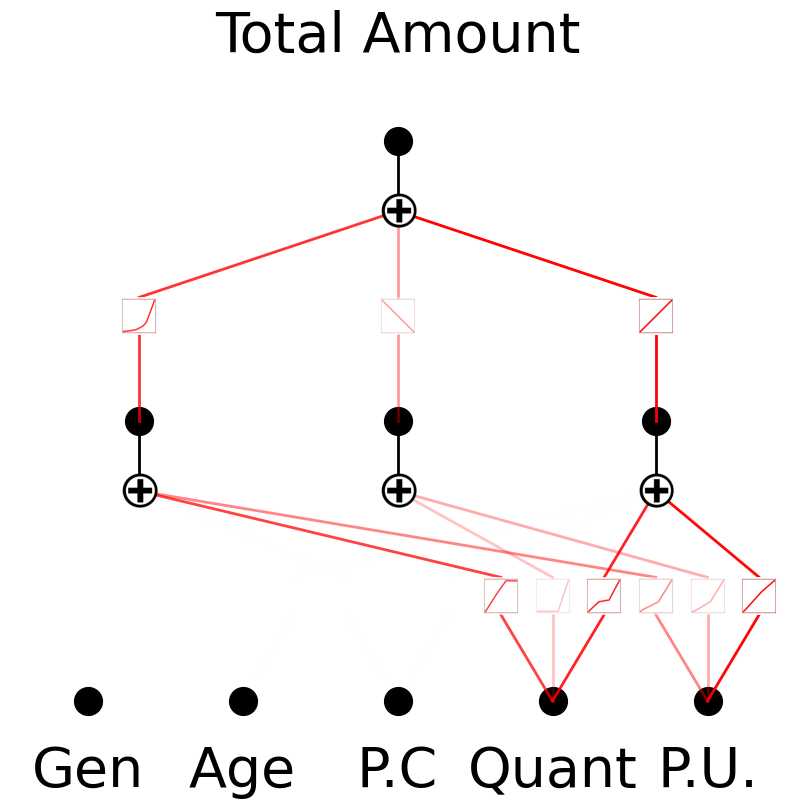

In [11]:
model = model.prune()
model(dataset['train_input'])
model.plot(scale=1, in_vars=['Gen','Age','P.C','Quant','P.U.'], out_vars=['Total Amount'])

In [12]:
formula = model.symbolic_formula()[0][0]
ex_round(formula, 4)

-0.2992*x_1 + 0.3695*x_2 + 0.0135*(0.2007 - x_2)**2 - 0.9709*(-0.2802*x_3 - 1)**2 - 24.3115*(-x_5 - 0.7259)**2 - 0.0002*exp(9.9247*x_4) + 63.3889*exp(0.0014*x_1 - 0.0017*x_2 - 0.0104*(1 - 0.1466*x_3)**2 - 1.7507*sin(8.223*x_4 + 6.9882) + 0.8905*sin(3.5895*x_5 - 4.9806)) + 536.744*sin(0.7387*x_5 - 0.1509) + 32.0374*tan(8.2068*x_4 - 3.0008) + 385.1541 - 0.0409*exp(-0.2559*x_3)